# Data Load

In [1]:
import pandas as pd

df = pd.read_csv('../NLME.csv', low_memory=False)
unique_labels = df['label'].unique()
print("Unique labels:", unique_labels)
label_counts = df['label'].value_counts()
print("Value counts:\n", label_counts)

df2 = pd.read_csv('../parsed_events (20).csv', low_memory=False)

unique_labels = df2['label'].unique()
print("Unique labels:", unique_labels)
label_counts = df2['label'].value_counts()
print("Value counts:\n", label_counts)

Unique labels: [0 1]
Value counts:
 label
0    53802
1    17215
Name: count, dtype: int64
Unique labels: [0 1]
Value counts:
 label
0    602450
1    162061
Name: count, dtype: int64


# Data Preprocess

In [2]:
df2.rename(columns={
    'target_file_name': 'TargetFilename',
    'event_id': 'EventID',
    'target_process_guid': 'TargetProcessGuid',
    'event_type': 'EventType',
    'target_image': 'TargetImage',
    'previous_creation_utc_time': 'PreviousCreationUtcTime',
    'destination_host_name': 'DestinationHostname',
    'company': 'Company',
    'description': 'Description',
    'product': 'Product',
    'integrity_level': 'IntegrityLevel',
    'creation_utc_time': 'CreationUtcTime',
    'start_function': 'StartFunction',
    'parent_process_id': 'ParentProcessGuid',
    'user': 'User',
    'logon_id': 'LogonId',
    'parent_process_id': 'ParentProcessId',
    'terminal_session_id': 'TerminalSessionId',
    'rule_name': 'RuleName',
    'target_object': 'TargetObject',
    'parent_process_guid': 'ParentProcessGuid'
    }, inplace=True)

In [3]:
important_columns = [
    'TargetFilename', 
    'EventID', 
    'TargetProcessGuid', 
    'EventType',
    'TargetImage', 
    'PreviousCreationUtcTime', 
    'DestinationHostname', 
    'Company', 
    'Description',
    'Product', 
    'IntegrityLevel', 
    'CreationUtcTime', 
    # 'StartFunction', 
    'ParentProcessGuid', 
    'User',
    'LogonId', 
    'ParentProcessId', 
    'TerminalSessionId', 
    'RuleName', 
    'TargetObject', 
    'label'
]

selected_df = df[important_columns]
selected_df2 = df2[important_columns]

## Data Split

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

def clean_and_encode(df):
    df = df.replace('-', np.nan)
    df = df.dropna(axis=1, how='all').drop_duplicates()
    le = LabelEncoder()
    filtered = []
    for col in df.columns:
        if col == 'label':
            continue
        if df[col].nunique() <= 25 and col != 'label':
            filtered.append(col)
            mask = df[col].isnull()
            df.loc[mask, col] = -1
            df.loc[~mask, col] = le.fit_transform(df[col][~mask])
        else:
            if df[col].dtype == "object":
                df[col] = df[col].str.len()
            df[col] = df[col].fillna(-1)
    return df, filtered

def preprocess_data_3(df, df2):
    df['label'] = df['label'].replace({1: -1, 0: 1})
    df2['label'] = df2['label'].replace({1: -1, 0: 1})
    df, filteredColumn = clean_and_encode(df)
    df2, _ = clean_and_encode(df2)
    
    benign_df = df[df['label'] == 1]
    malware_df = df[df['label'] == -1]
    train_df = benign_df.iloc[malware_df.shape[0]:]
    test_df = pd.concat([benign_df.iloc[:malware_df.shape[0]], malware_df])

    benign_df2 = df2[df2['label'] == 1]
    malware_df2 = df2[df2['label'] == -1]
    
    print(filteredColumn)

    train_means = benign_df[filteredColumn].mean()
    test_means = benign_df2[filteredColumn].mean()

    abs_diff = (train_means - test_means).abs()
    df_diff = pd.DataFrame({
        "Train means": train_means,
        "Test means": test_means,
        "Diff": abs_diff
    }).sort_values(by="Diff", ascending=False)

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=range(len(filteredColumn)), y=train_means.values, label="Train Benign")
    sns.lineplot(x=range(len(filteredColumn)), y=test_means.values, label="Test Benign")
    plt.xticks(range(len(filteredColumn)), filteredColumn, rotation=90)
    plt.title("Feature Distribution Shift (Benign)")
    plt.tight_layout()
    plt.show()

    benign_shuffled = benign_df2.sample(frac=1, random_state=42).reset_index(drop=True)
    malware_shuffled = malware_df2.sample(frac=1, random_state=123).reset_index(drop=True)  # Different seed
    
    min_size = min(len(benign_shuffled), len(malware_shuffled))
    benign_for_test = benign_shuffled.iloc[:min_size]
    malware_for_test = malware_shuffled.iloc[:min_size]
    
    benign_test_chunks = np.array_split(benign_for_test, 10)
    malware_test_chunks = np.array_split(malware_for_test, 10)
    
    test_df2 = pd.concat([benign_for_test, malware_for_test])
    test_chunks = []
    for i in range(10):
        combined_chunk = pd.concat([benign_test_chunks[i], malware_test_chunks[i]], ignore_index=True)
        combined_chunk = combined_chunk.sample(frac=1, random_state=i*10).reset_index(drop=True)
        test_chunks.append(combined_chunk)
        print(f"Test chunk {i+1}: {len(combined_chunk)} samples, "
              f"benign: {len(combined_chunk[combined_chunk['label']==1])}, "
              f"malware: {len(combined_chunk[combined_chunk['label']==-1])}")
    
    remaining_benign = benign_shuffled.iloc[min_size:] if len(benign_shuffled) > min_size else benign_shuffled
    
    train_chunks = []
    for i in range(10):
        if len(remaining_benign) > 1000:  # If we have enough data
            train_sample = remaining_benign.sample(n=min(len(remaining_benign), 5000), 
                                                 random_state=i*100, 
                                                 replace=False).reset_index(drop=True)
        else:
            train_sample = remaining_benign.sample(n=5000, 
                                                 random_state=i*100, 
                                                 replace=True).reset_index(drop=True)
        
        train_chunks.append(train_sample)
        print(f"Train chunk {i+1}: {len(train_sample)} benign samples")
    
    print("\nVerifying chunk diversity:")
    for i in range(min(5, len(train_chunks)-1)):
        similarity = len(pd.merge(train_chunks[i], train_chunks[i+1], how='inner')) / len(train_chunks[i])
        print(f"Train chunks {i+1} and {i+2} similarity: {similarity:.2%}")
    
    for i in range(min(5, len(test_chunks)-1)):
        similarity = len(pd.merge(test_chunks[i], test_chunks[i+1], how='inner')) / len(test_chunks[i])
        print(f"Test chunks {i+1} and {i+2} similarity: {similarity:.2%}")

    return df, train_df, test_df, df2, train_chunks, test_chunks, remaining_benign, pd.concat([benign_df2.iloc[:min_size], malware_df2.iloc[:min_size]])


/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_17005/3903420739.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].replace({1: -1, 0: 1})
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_17005/3903420739.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['label'] = df2['label'].replace({1: -1, 0: 1})


['EventID', 'EventType', 'TargetImage', 'DestinationHostname', 'IntegrityLevel', 'User', 'TerminalSessionId', 'RuleName']


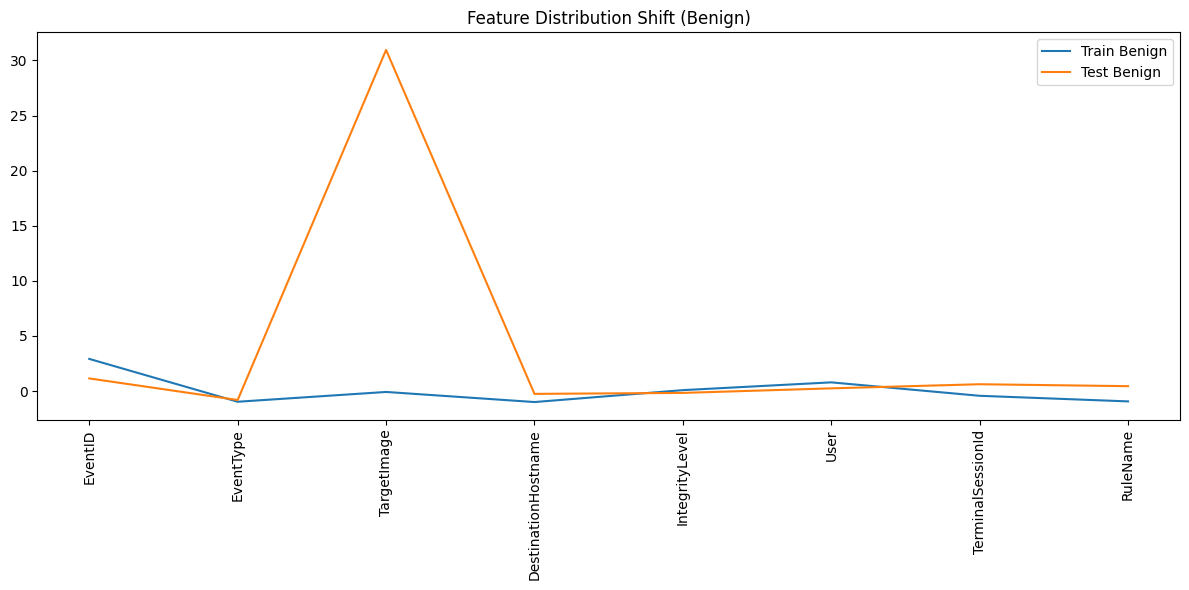

/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Test chunk 1: 14044 samples, benign: 7022, malware: 7022
Test chunk 2: 14044 samples, benign: 7022, malware: 7022
Test chunk 3: 14044 samples, benign: 7022, malware: 7022
Test chunk 4: 14042 samples, benign: 7021, malware: 7021
Test chunk 5: 14042 samples, benign: 7021, malware: 7021
Test chunk 6: 14042 samples, benign: 7021, malware: 7021
Test chunk 7: 14042 samples, benign: 7021, malware: 7021
Test chunk 8: 14042 samples, benign: 7021, malware: 7021
Test chunk 9: 14042 samples, benign: 7021, malware: 7021
Test chunk 10: 14042 samples, benign: 7021, malware: 7021
Train chunk 1: 5000 benign samples
Train chunk 2: 5000 benign samples
Train chunk 3: 5000 benign samples
Train chunk 4: 5000 benign samples
Train chunk 5: 5000 benign samples
Train chunk 6: 5000 benign samples
Train chunk 7: 5000 benign samples
Train chunk 8: 5000 benign samples
Train chunk 9: 5000 benign samples
Train chunk 10: 5000 benign samples

Verifying chunk diversity:
Train chunks 1 and 2 similarity: 439.66%
Train chu

In [5]:
ndf, train_df, test_df, ndf2, train_chunks, test_chunks, train_df2, test_df2 = preprocess_data_3(selected_df, selected_df2)

In [ ]:
def count_stats(df, outlier=1, label=1):
    tmp = df.apply(lambda x : True if x['outlier'] == outlier and x['label'] == label else False, axis = 1)
    return len(tmp[tmp == True].index)

def test_model(clf, df):
    X_test = df.drop('label', axis=1)
    outliers_predicted = clf.predict(X_test)
    new_df = df.copy()
    new_df['outlier'] = outliers_predicted
    tp = count_stats(new_df, outlier=-1, label=-1)
    fn = count_stats(new_df, outlier=1, label=-1)
    fp = count_stats(new_df, outlier=-1, label=1)
    tn = count_stats(new_df, outlier=1, label=1)

    # conf_matrix = pd.DataFrame(
    #     [[tp, fn],
    #      [fp, tn]],
    #     columns=['Actual outlier', 'Actual inlier'],
    #     index=['Predicted outlier', 'Predicted inlier']
    # )

    # plt.figure(figsize=(6, 4))
    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='grey_r')
    # plt.title('Confusion Matrix')
    # plt.show()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2 * (recall * precision) / (precision + recall)
    return new_df, recall, precision, f1, tp, fn, fp, tn

# OCSVM

### Search best params

In [7]:
import time
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
import joblib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def test_model_wrapper(model, test_data):
    """
    Wrapper function for your existing test_model function
    Replace this with your actual test_model implementation
    """
    # Assuming test_model returns (predictions, recall, precision, f1)
    # You'll need to replace this with your actual test_model function
    pass

def evaluate_one_class_svm_parameters(train_df, test_df, test_df2=None, scale_data=True):
    """
    Comprehensive parameter selection for OneClassSVM
    """
    
    # Define parameter grid for testing
    param_grid = {
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
        'nu': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        'degree': [2, 3, 4, 5],  # Only used for poly kernel
        'coef0': [0.0, 0.1, 1.0],  # Only used for poly and sigmoid
        'tol': [1e-3, 1e-4, 1e-5],
        'shrinking': [True, False]
    }
    
    # For quick testing, use a smaller grid
    quick_param_grid = {
        'kernel': ['rbf', 'linear', 'poly'],
        'gamma': ['scale', 0.01, 0.1, 1],
        'nu': [0.1, 0.2, 0.3],
        'degree': [3],  # Default for poly
        'coef0': [0.0],  # Default
        'tol': [1e-3],  # Default
        'shrinking': [True]  # Default
    }
    
    X_train = train_df.drop('label', axis=1)
    
    # Scale data if requested (highly recommended for SVM)
    scaler = None
    if scale_data:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
    else:
        X_train_scaled = X_train
    
    results = []
    
    print("Starting parameter grid search for One-Class SVM...")
    print(f"Data scaling: {'Enabled' if scale_data else 'Disabled'}")
    print(f"Total combinations to test: {len(list(ParameterGrid(quick_param_grid)))}")
    
    for i, params in enumerate(ParameterGrid(quick_param_grid)):
        try:
            # Skip invalid parameter combinations
            if params['kernel'] not in ['poly', 'sigmoid'] and params['coef0'] != 0.0:
                continue
            if params['kernel'] != 'poly' and params['degree'] != 3:
                continue
                
            print(f"\nTesting combination {i+1}: {params}")
            
            # Create and train model
            start_train = time.time()
            svm = OneClassSVM(**params)
            svm.fit(X_train_scaled)
            train_time = time.time() - start_train
            
            # Create a wrapper model that includes scaling
            if scale_data:
                model_wrapper = SVMWrapper(svm, scaler)
            else:
                model_wrapper = svm
            
            # Test on first dataset
            start_test1 = time.time()
            _, recall_1, precision_1, f1_1 = test_model(model_wrapper, test_df)
            test1_time = time.time() - start_test1
            
            # Test on second dataset if provided
            if test_df2 is not None:
                start_test2 = time.time()
                _, recall_2, precision_2, f1_2 = test_model(model_wrapper, test_df2)
                test2_time = time.time() - start_test2
            else:
                recall_2 = precision_2 = f1_2 = test2_time = 0
            
            # Store results
            result = {
                'params': params,
                'train_time': train_time,
                'test1_precision': precision_1,
                'test1_recall': recall_1,
                'test1_f1': f1_1,
                'test1_time': test1_time,
                'test2_precision': precision_2,
                'test2_recall': recall_2,
                'test2_f1': f1_2,
                'test2_time': test2_time,
                'avg_f1': (f1_1 + f1_2) / 2 if test_df2 is not None else f1_1,
                'scaled': scale_data
            }
            results.append(result)
            
            print(f"Test1 - Precision: {precision_1:.4f}, Recall: {recall_1:.4f}, F1: {f1_1:.4f}")
            if test_df2 is not None:
                print(f"Test2 - Precision: {precision_2:.4f}, Recall: {recall_2:.4f}, F1: {f1_2:.4f}")
            
        except Exception as e:
            print(f"Error with params {params}: {str(e)}")
            continue
    
    return results, scaler

class SVMWrapper:
    """
    Wrapper class to handle scaling with SVM model
    """
    def __init__(self, svm_model, scaler):
        self.svm_model = svm_model
        self.scaler = scaler
    
    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return self.svm_model.predict(X_scaled)
    
    def decision_function(self, X):
        X_scaled = self.scaler.transform(X)
        return self.svm_model.decision_function(X_scaled)

def analyze_results(results):
    """
    Analyze and display the best parameter combinations
    """
    if not results:
        print("No results to analyze!")
        return None
    
    # Convert to DataFrame for easier analysis
    df_results = []
    for result in results:
        row = result['params'].copy()
        row.update({k: v for k, v in result.items() if k != 'params'})
        df_results.append(row)
    
    df = pd.DataFrame(df_results)
    
    print("\n" + "="*80)
    print("ONE-CLASS SVM PARAMETER ANALYSIS RESULTS")
    print("="*80)
    
    # Best overall F1 score
    best_idx = df['avg_f1'].idxmax()
    best_result = results[best_idx]
    
    print(f"\nBEST OVERALL PARAMETERS (Highest Average F1: {best_result['avg_f1']:.4f}):")
    print("-" * 60)
    for param, value in best_result['params'].items():
        print(f"{param}: {value}")
    
    print(f"\nPerformance:")
    print(f"Test1 - Precision: {best_result['test1_precision']:.4f}, Recall: {best_result['test1_recall']:.4f}, F1: {best_result['test1_f1']:.4f}")
    print(f"Test2 - Precision: {best_result['test2_precision']:.4f}, Recall: {best_result['test2_recall']:.4f}, F1: {best_result['test2_f1']:.4f}")
    print(f"Training time: {best_result['train_time']:.4f}s")
    
    # Top 5 combinations
    print(f"\nTOP 5 PARAMETER COMBINATIONS:")
    print("-" * 60)
    top_5 = df.nlargest(5, 'avg_f1')
    for i, (idx, row) in enumerate(top_5.iterrows()):
        print(f"\n{i+1}. F1: {row['avg_f1']:.4f} (Training time: {row['train_time']:.2f}s)")
        print(f"   kernel: {row['kernel']}, gamma: {row['gamma']}, nu: {row['nu']}")
        if row['kernel'] == 'poly':
            print(f"   degree: {row['degree']}, coef0: {row['coef0']}")
        print(f"   tol: {row['tol']}, shrinking: {row['shrinking']}")
    
    # Kernel performance analysis
    print(f"\nKERNEL PERFORMANCE ANALYSIS:")
    print("-" * 60)
    kernel_analysis = df.groupby('kernel').agg({
        'avg_f1': ['mean', 'std', 'max', 'count'],
        'train_time': ['mean', 'std']
    }).round(4)
    
    for kernel in df['kernel'].unique():
        kernel_data = df[df['kernel'] == kernel]
        print(f"\n{kernel.upper()} KERNEL:")
        print(f"  Mean F1: {kernel_data['avg_f1'].mean():.4f} (±{kernel_data['avg_f1'].std():.4f})")
        print(f"  Best F1: {kernel_data['avg_f1'].max():.4f}")
        print(f"  Mean training time: {kernel_data['train_time'].mean():.4f}s (±{kernel_data['train_time'].std():.4f})")
        print(f"  Count: {len(kernel_data)}")
    
    # Nu parameter analysis
    print(f"\nNU PARAMETER ANALYSIS:")
    print("-" * 60)
    for nu in sorted(df['nu'].unique()):
        nu_data = df[df['nu'] == nu]
        print(f"  nu={nu}: Mean F1={nu_data['avg_f1'].mean():.4f} (±{nu_data['avg_f1'].std():.4f}), Count={len(nu_data)}")
    
    # Gamma parameter analysis (for RBF kernel)
    rbf_data = df[df['kernel'] == 'rbf']
    if not rbf_data.empty:
        print(f"\nGAMMA PARAMETER ANALYSIS (RBF Kernel only):")
        print("-" * 60)
        for gamma in rbf_data['gamma'].unique():
            gamma_data = rbf_data[rbf_data['gamma'] == gamma]
            print(f"  gamma={gamma}: Mean F1={gamma_data['avg_f1'].mean():.4f} (±{gamma_data['avg_f1'].std():.4f}), Count={len(gamma_data)}")
    
    # Training time analysis
    print(f"\nTRAINING TIME ANALYSIS:")
    print("-" * 60)
    print(f"Average training time: {df['train_time'].mean():.4f}s")
    print(f"Fastest training: {df['train_time'].min():.4f}s")
    print(f"Slowest training: {df['train_time'].max():.4f}s")
    
    # Find best balance of performance and speed
    df['efficiency_score'] = df['avg_f1'] / (df['train_time'] + 1e-6)
    best_efficiency_idx = df['efficiency_score'].idxmax()
    best_efficiency = results[best_efficiency_idx]
    
    print(f"\nBEST EFFICIENCY (F1/Time Ratio: {df.loc[best_efficiency_idx, 'efficiency_score']:.4f}):")
    print("-" * 60)
    for param, value in best_efficiency['params'].items():
        print(f"{param}: {value}")
    print(f"F1: {best_efficiency['avg_f1']:.4f}, Training time: {best_efficiency['train_time']:.4f}s")
    
    return best_result

def kernel_specific_analysis(results):
    """
    Detailed analysis for each kernel type
    """
    df_results = []
    for result in results:
        row = result['params'].copy()
        row.update({k: v for k, v in result.items() if k != 'params'})
        df_results.append(row)
    
    df = pd.DataFrame(df_results)
    
    print(f"\nKERNEL-SPECIFIC RECOMMENDATIONS:")
    print("="*60)
    
    for kernel in df['kernel'].unique():
        kernel_data = df[df['kernel'] == kernel]
        best_kernel = kernel_data.loc[kernel_data['avg_f1'].idxmax()]
        
        print(f"\n{kernel.upper()} KERNEL:")
        print(f"  Best F1: {best_kernel['avg_f1']:.4f}")
        print(f"  Best parameters:")
        for param in ['gamma', 'nu', 'degree', 'coef0', 'tol', 'shrinking']:
            if param in best_kernel:
                print(f"    {param}: {best_kernel[param]}")
        print(f"  Training time: {best_kernel['train_time']:.4f}s")
        
        # Recommendations
        if kernel == 'rbf':
            print(f"  Recommendation: Good all-around choice, tune gamma and nu carefully")
        elif kernel == 'linear':
            print(f"  Recommendation: Fast and interpretable, good for high-dimensional data")
        elif kernel == 'poly':
            print(f"  Recommendation: Can capture complex patterns, tune degree parameter")
        elif kernel == 'sigmoid':
            print(f"  Recommendation: Similar to neural networks, tune gamma and coef0")

# Main execution function
def optimize_one_class_svm_parameters(train_df, test_df, test_df2=None, scale_data=True):
    """
    Main function to optimize One-Class SVM parameters
    """
    print("One-Class SVM Parameter Optimization")
    print("="*50)
    
    # Run parameter search
    results, scaler = evaluate_one_class_svm_parameters(train_df, test_df, test_df2, scale_data)
    
    # Analyze results
    best_params = analyze_results(results)
    
    # Kernel-specific analysis
    kernel_specific_analysis(results)
    
    if best_params:
        # Train final model with best parameters
        print(f"\n" + "="*80)
        print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
        print("="*80)
        
        X_train = train_df.drop('label', axis=1)
        
        if scale_data:
            X_train_scaled = scaler.transform(X_train)
            final_svm = OneClassSVM(**best_params['params'])
            final_svm.fit(X_train_scaled)
            
            # Create wrapper model
            final_model = SVMWrapper(final_svm, scaler)
        else:
            final_svm = OneClassSVM(**best_params['params'])
            final_svm.fit(X_train)
            final_model = final_svm
        
        # Save the best model and scaler
        model_data = {
            'model': final_svm,
            'scaler': scaler if scale_data else None,
            'best_params': best_params['params'],
            'scaled': scale_data
        }
        joblib.dump(model_data, 'one_class_svm_optimized.joblib')
        print("Best model saved as 'one_class_svm_optimized.joblib'")
        
        return final_model, best_params
    
    return None, None

def get_parameter_suggestions():
    """
    Returns suggested parameter combinations based on common practices for One-Class SVM
    """
    suggestions = {
        'small_datasets_rbf': {
            'kernel': 'rbf',
            'gamma': 'scale',
            'nu': 0.1,
            'tol': 1e-3,
            'shrinking': True
        },
        'medium_datasets_rbf': {
            'kernel': 'rbf',
            'gamma': 0.1,
            'nu': 0.2,
            'tol': 1e-4,
            'shrinking': True
        },
        'large_datasets_linear': {
            'kernel': 'linear',
            'nu': 0.2,
            'tol': 1e-3,
            'shrinking': True
        },
        'high_dimensional_linear': {
            'kernel': 'linear',
            'nu': 0.1,
            'tol': 1e-4,
            'shrinking': False
        },
        'complex_patterns_poly': {
            'kernel': 'poly',
            'degree': 3,
            'gamma': 'scale',
            'nu': 0.2,
            'coef0': 0.0,
            'tol': 1e-3,
            'shrinking': True
        },
        'speed_optimized_linear': {
            'kernel': 'linear',
            'nu': 0.2,
            'tol': 1e-2,
            'shrinking': True
        },
        'accuracy_optimized_rbf': {
            'kernel': 'rbf',
            'gamma': 0.01,
            'nu': 0.05,
            'tol': 1e-5,
            'shrinking': True
        }
    }
    
    print("ONE-CLASS SVM PARAMETER SUGGESTIONS BY USE CASE:")
    print("="*60)
    for use_case, params in suggestions.items():
        print(f"\n{use_case.upper().replace('_', ' ')}:")
        for param, value in params.items():
            print(f"  {param}: {value}")
    
    return suggestions

def quick_nu_test(train_df, test_df, nu_values=None, kernel='rbf', scale_data=True):
    """
    Quick test of different nu values with default parameters
    """
    if nu_values is None:
        nu_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    
    print("QUICK NU PARAMETER TEST:")
    print("="*50)
    
    X_train = train_df.drop('label', axis=1)
    
    # Scale data if requested
    if scale_data:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
    else:
        X_train_scaled = X_train
        scaler = None
    
    results = []
    
    base_params = {
        'kernel': kernel,
        'gamma': 'scale',
        'tol': 1e-3,
        'shrinking': True
    }
    
    for nu in nu_values:
        try:
            params = base_params.copy()
            params['nu'] = nu
            
            svm = OneClassSVM(**params)
            svm.fit(X_train_scaled)
            
            if scale_data:
                model_wrapper = SVMWrapper(svm, scaler)
            else:
                model_wrapper = svm
            
            _, recall, precision, f1 = test_model(model_wrapper, test_df)
            
            results.append({
                'nu': nu,
                'precision': precision,
                'recall': recall,
                'f1': f1
            })
            
            print(f"Nu {nu}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
            
        except Exception as e:
            print(f"Error with nu {nu}: {str(e)}")
    
    if results:
        best_result = max(results, key=lambda x: x['f1'])
        print(f"\nBest nu: {best_result['nu']} (F1: {best_result['f1']:.4f})")
        return best_result['nu']
    
    return None

def progressive_parameter_tuning(train_df, test_df, test_df2=None):
    """
    Progressive approach to parameter tuning
    """
    print("PROGRESSIVE PARAMETER TUNING FOR ONE-CLASS SVM:")
    print("="*60)
    
    print("\nStep 1: Find best kernel...")
    kernels = ['rbf', 'linear', 'poly']
    kernel_results = []
    
    for kernel in kernels:
        try:
            X_train = train_df.drop('label', axis=1)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            
            svm = OneClassSVM(kernel=kernel, nu=0.2, gamma='scale')
            svm.fit(X_train_scaled)
            
            model_wrapper = SVMWrapper(svm, scaler)
            _, recall, precision, f1 = test_model(model_wrapper, test_df)
            
            kernel_results.append({'kernel': kernel, 'f1': f1})
            print(f"{kernel}: F1={f1:.4f}")
            
        except Exception as e:
            print(f"Error with {kernel}: {str(e)}")
    
    best_kernel = max(kernel_results, key=lambda x: x['f1'])['kernel']
    print(f"Best kernel: {best_kernel}")
    
    print(f"\nStep 2: Optimize nu for {best_kernel} kernel...")
    best_nu = quick_nu_test(train_df, test_df, kernel=best_kernel)
    
    print(f"\nStep 3: Fine-tune other parameters...")
    print("Run full optimization with narrowed parameter ranges based on findings above.")
    
    return best_kernel, best_nu

# Example usage:
if __name__ == "__main__":
    # Method 1: Full grid search (recommended)
    final_model, best_params = optimize_one_class_svm_parameters(train_df, test_df, test_df2)
    
    # Method 2: Parameter suggestions
    suggestions = get_parameter_suggestions()
    
    # Method 3: Quick nu test
    best_nu = quick_nu_test(train_df, test_df)
    
    # Method 4: Progressive tuning
    best_kernel, best_nu = progressive_parameter_tuning(train_df, test_df, test_df2)
    
    # Method 5: Manual testing with specific combinations
    test_combinations = [
        {'kernel': 'rbf', 'gamma': 'scale', 'nu': 0.1, 'tol': 1e-3, 'shrinking': True},
        {'kernel': 'linear', 'nu': 0.2, 'tol': 1e-4, 'shrinking': True},
        {'kernel': 'poly', 'degree': 3, 'gamma': 0.1, 'nu': 0.2, 'coef0': 0.0, 'tol': 1e-3, 'shrinking': True},
    ]
    
    print(f"\nTEST COMBINATIONS FOR MANUAL EVALUATION:")
    print("-" * 50)
    for i, combo in enumerate(test_combinations, 1):
        print(f"{i}. {combo}")
    
    # Important notes for One-Class SVM
    print(f"\nIMPORTANT NOTES FOR ONE-CLASS SVM:")
    print("-" * 50)
    print("1. ALWAYS scale your data - SVM is sensitive to feature scales")
    print("2. Nu parameter controls the fraction of outliers (0 < nu <= 1)")
    print("3. RBF kernel is usually a good starting point")
    print("4. Linear kernel is faster and works well for high-dimensional data")
    print("5. Gamma parameter controls the influence of single training examples")
    print("6. Lower nu = stricter anomaly detection, higher nu = more lenient")
    
    # Load saved model example
    print(f"\nLOADING SAVED MODEL:")
    print("-" * 50)
    print("# To load the saved model:")
    print("model_data = joblib.load('one_class_svm_optimized.joblib')")
    print("if model_data['scaled']:")
    print("    final_model = SVMWrapper(model_data['model'], model_data['scaler'])")
    print("else:")
    print("    final_model = model_data['model']")
    print("predictions = final_model.predict(new_data)")

One-Class SVM Parameter Optimization
Starting parameter grid search for One-Class SVM...
Data scaling: Enabled
Total combinations to test: 36

Testing combination 1: {'coef0': 0.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.1, 'shrinking': True, 'tol': 0.001}


KeyboardInterrupt: 

### Real OCSVM

Data training:
Precision: 0.605, Recall: 0.918, F1-score: 0.730
Time execution: 3.0774
Data testing:
Precision: 0.500, Recall: 1.000, F1-score: 0.667
Time execution: 43.7659


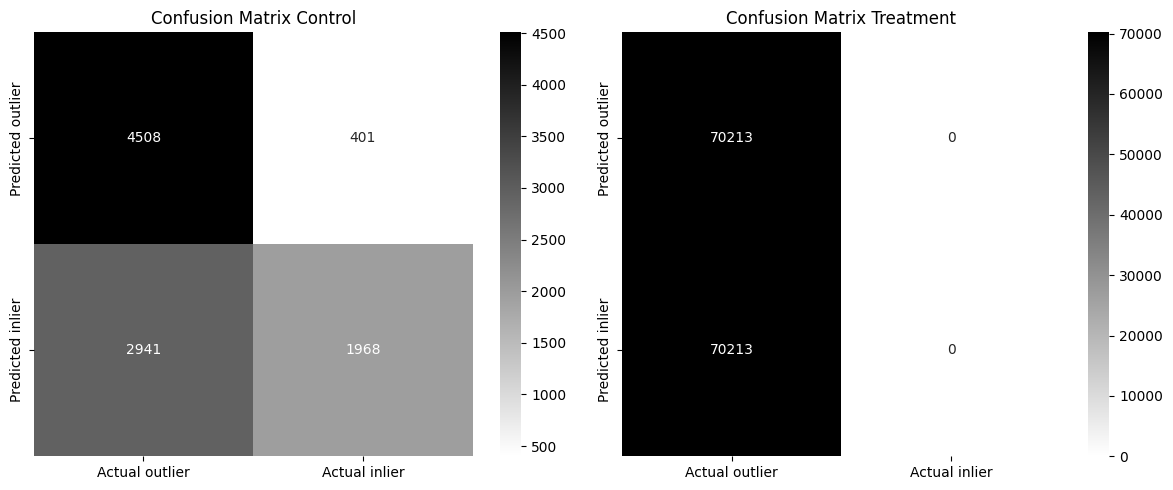

In [8]:
from sklearn.svm import OneClassSVM
import time
import joblib

lof = OneClassSVM(coef0= 0.0,
    degree=3,
    gamma=1,
    kernel='rbf',
    nu=0.3,
    shrinking=True,
    tol=0.001)
X_train = train_df.drop('label', axis=1)
lof.fit(X_train)

start = time.time()
_, recall, precision, f1, tp, fn, fp, tn = test_model(lof, test_df)
end = time.time()
elapsed = end-start

print('Data training:')
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")
print(f"Time execution: {elapsed:.4f}")

start = time.time()
_, recall_2, precision_2, f1_2, tp_2, fn_2, fp_2, tn_2 = test_model(lof, test_df2)
end = time.time()
elapsed = end-start

print('Data testing:')
print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
print(f"Time execution: {elapsed:.4f}")

conf_matrix = pd.DataFrame(
    [[tp, fn],
    [fp, tn]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

conf_matrix_2 = pd.DataFrame(
    [[tp_2, fn_2],
    [fp_2, tn_2]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='grey_r', ax=axs[0])
axs[0].set_title("Confusion Matrix Control")
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='grey_r', ax=axs[1])
axs[1].set_title("Confusion Matrix Treatment")

plt.tight_layout()
plt.show()

# Retraining

### a. Concat old + new data (50:50)

In [11]:
retrain_df = pd.concat([train_df2.iloc[:train_df.shape[0], :], train_df])
lof = OneClassSVM(coef0= 0.0,
    degree=3,
    gamma=1,
    kernel='rbf',
    nu=0.3,
    shrinking=True,
    tol=0.001)
X_train = retrain_df.drop('label', axis=1)
lof.fit(X_train)
joblib.dump(lof, 'ocsvmretrain.joblib')

['ocsvmretrain.joblib']

Data training:
Precision: 0.545, Recall: 0.833, F1-score: 0.659
Time execution: 8.7393
Data testing:
Precision: 0.585, Recall: 0.998, F1-score: 0.738
Time execution: 124.1699


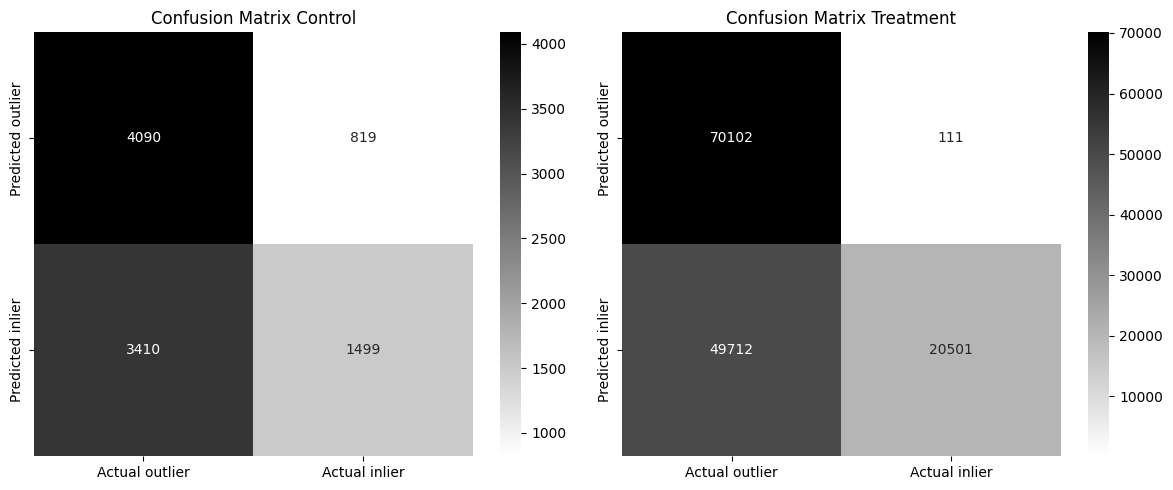

In [12]:
lof = joblib.load('ocsvmretrain.joblib')

start = time.time()
_, recall, precision, f1, tp, fn, fp, tn = test_model(lof, test_df)
end = time.time()
elapsed = end-start

print('Data training:')
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")
print(f"Time execution: {elapsed:.4f}")

start = time.time()
_, recall_2, precision_2, f1_2, tp_2, fn_2, fp_2, tn_2 = test_model(lof, test_df2)
end = time.time()
elapsed = end-start

print('Data testing:')
print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
print(f"Time execution: {elapsed:.4f}")

conf_matrix = pd.DataFrame(
    [[tp, fn],
    [fp, tn]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

conf_matrix_2 = pd.DataFrame(
    [[tp_2, fn_2],
    [fp_2, tn_2]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='grey_r', ax=axs[0])
axs[0].set_title("Confusion Matrix Control")
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='grey_r', ax=axs[1])
axs[1].set_title("Confusion Matrix Treatment")

plt.tight_layout()
plt.show()

### b. Full model replacement with new data

Data testing:
Precision: 0.618, Recall: 0.999, F1-score: 0.764
Time execution: 1198.0070


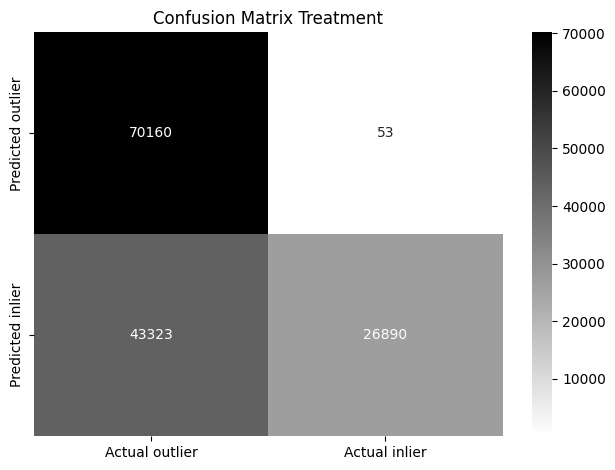

In [15]:
lof = OneClassSVM(coef0= 0.0,
    degree=3,
    gamma=1,
    kernel='rbf',
    nu=0.3,
    shrinking=True,
    tol=0.001)
X_train = train_df2.drop('label', axis=1)
lof.fit(X_train)
joblib.dump(lof, 'lof2.joblib')

lof = joblib.load('lof2.joblib')
start = time.time()
_, recall_2, precision_2, f1_2, tp_2, fn_2, fp_2, tn_2 = test_model(lof, test_df2)
end = time.time()
elapsed = end-start

print('Data testing:')
print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
print(f"Time execution: {elapsed:.4f}")

conf_matrix_2 = pd.DataFrame(
    [[tp_2, fn_2],
    [fp_2, tn_2]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

fig, axs= plt.subplots()
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='grey_r', ax=axs)
axs.set_title("Confusion Matrix Treatment")
# sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='grey_r', ax=axs[1])
# axs[1].set_title("Confusion Matrix Treatment")

plt.tight_layout()
plt.show()

### c. Continuous retraining

In [11]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
import joblib

previous_results = None

for i in range(10):
    print(f'Data testing {i+1}:')
    
    training_data = train_chunks[i][train_chunks[i]['label'] == 1].copy()
    print(f"Training on {len(training_data)} samples")
    
    lof = OneClassSVM(coef0= 0.0,
    degree=3,
    gamma=1,
    kernel='rbf',
    nu=0.3,
    shrinking=True,
    tol=0.001)
    X_train = training_data.drop('label', axis=1)
    lof.fit(X_train)
    joblib.dump(lof, f'lofretrain{i+1}.joblib')
    
    iso = joblib.load(f'lofretrain{i+1}.joblib')
    
    test_data = test_chunks[i].copy()
    print(f"Testing on {len(test_data)} samples")
    
    start = time.time()
    current_results, recall_2, precision_2, f1_2 = test_model(lof, test_data)
    end = time.time()
    elapsed = end-start
    print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
    print(f"Time execution: {elapsed:.4f}")

    
    if previous_results is not None:
        print("\n--- McNemar Test Analysis ---")
        
        if 'outlier' in current_results.columns and 'outlier' in previous_results.columns:
            both_anomaly = len(current_results[
                (current_results['outlier'] == -1) & 
                (previous_results['outlier'] == -1)
            ])
            
            curr_anom_prev_norm = len(current_results[
                (current_results['outlier'] == -1) & 
                (previous_results['outlier'] == 1)
            ])
            
            curr_norm_prev_anom = len(current_results[
                (current_results['outlier'] == 1) & 
                (previous_results['outlier'] == -1)
            ])
            
            both_normal = len(current_results[
                (current_results['outlier'] == 1) & 
                (previous_results['outlier'] == 1)
            ])
            
            print(f"Agreement - Both anomaly: {both_anomaly}")
            print(f"Agreement - Both normal: {both_normal}")
            print(f"Disagreement - Current anomaly, Previous normal: {curr_anom_prev_norm}")
            print(f"Disagreement - Current normal, Previous anomaly: {curr_norm_prev_anom}")
            
            total_disagreements = curr_anom_prev_norm + curr_norm_prev_anom
            total_samples = both_anomaly + both_normal + total_disagreements
            agreement_rate = (both_anomaly + both_normal) / total_samples
            
            print(f"Total disagreements: {total_disagreements}")
            print(f"Agreement rate: {agreement_rate:.3f}")
            
            if total_disagreements > 0:
                mcnemar_table = np.array([
                    [both_anomaly, curr_anom_prev_norm], 
                    [curr_norm_prev_anom, both_normal]
                ])
                
                print(f"McNemar Table:")
                print(f"                Previous Model")
                print(f"               Anomaly  Normal")
                print(f"Current Anomaly   {both_anomaly:4d}    {curr_anom_prev_norm:4d}")
                print(f"        Normal    {curr_norm_prev_anom:4d}    {both_normal:4d}")
                
                try:
                    result = mcnemar(mcnemar_table, exact=False, correction=True)
                    print(f"McNemar Statistic: {result.statistic:.4f}")
                    print(f"McNemar p-value: {result.pvalue:.2f}")
                    
                    if result.pvalue < 0.001:
                        print("*** Highly significant difference between models (p < 0.001)")
                    elif result.pvalue < 0.01:
                        print("** Significant difference between models (p < 0.01)")
                    elif result.pvalue < 0.05:
                        print("* Marginally significant difference between models (p < 0.05)")
                    else:
                        print("No significant difference between models (p >= 0.05)")
                        
                except Exception as e:
                    print(f"Error in McNemar test: {e}")
            else:
                print("No disagreements between models - McNemar test not applicable")
        else:
            print("Missing 'outlier' column in results - cannot perform McNemar test")
    elif previous_results is not None:
        print(f"Warning: Result sizes don't match - Current: {len(current_results)}, Previous: {len(previous_results)}")
    else:
        print("First iteration - no previous model to compare")
    
    previous_results = current_results.copy()
    
    print("-" * 80)
    print()

print("Model retraining and comparison completed!")

Data testing 1:
Training on 5000 samples
Testing on 14044 samples
Precision: 0.469, Recall: 0.781, F1-score: 0.586
Time execution: 2.2732
First iteration - no previous model to compare
--------------------------------------------------------------------------------

Data testing 2:
Training on 5000 samples
Testing on 14044 samples
Precision: 0.520, Recall: 0.997, F1-score: 0.683
Time execution: 2.2900

--- McNemar Test Analysis ---
Agreement - Both anomaly: 11223
Agreement - Both normal: 95
Disagreement - Current anomaly, Previous normal: 2251
Disagreement - Current normal, Previous anomaly: 475
Total disagreements: 2726
Agreement rate: 0.806
McNemar Table:
                Previous Model
               Anomaly  Normal
Current Anomaly   11223    2251
        Normal     475      95
McNemar Statistic: 1155.7685
McNemar p-value: 0.00
*** Highly significant difference between models (p < 0.001)
--------------------------------------------------------------------------------

Data testing 3:

/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_50577/3329170326.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  both_anomaly = len(current_results[
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_50577/3329170326.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curr_anom_prev_norm = len(current_results[
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_50577/3329170326.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curr_norm_prev_anom = len(current_results[
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_50577/3329170326.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  both_normal = len(current_results[


Testing on 14042 samples
Precision: 0.526, Recall: 0.999, F1-score: 0.690
Time execution: 2.2637

--- McNemar Test Analysis ---
Agreement - Both anomaly: 11271
Agreement - Both normal: 99
Disagreement - Current anomaly, Previous normal: 2058
Disagreement - Current normal, Previous anomaly: 614
Total disagreements: 2672
Agreement rate: 0.810
McNemar Table:
                Previous Model
               Anomaly  Normal
Current Anomaly   11271    2058
        Normal     614      99
McNemar Statistic: 779.2848
McNemar p-value: 0.00
*** Highly significant difference between models (p < 0.001)
--------------------------------------------------------------------------------

Data testing 6:
Training on 5000 samples
Testing on 14042 samples
Precision: 0.530, Recall: 0.999, F1-score: 0.693
Time execution: 2.2802

--- McNemar Test Analysis ---
Agreement - Both anomaly: 12562
Agreement - Both normal: 52
Disagreement - Current anomaly, Previous normal: 661
Disagreement - Current normal, Previous an